In [ ]:
!git clone https://github.com/rasbt/deeplearning-models



fatal: destination path 'deeplearning-models' already exists and is not an empty directory.


In [ ]:
%cd deeplearning-models/pytorch_ipynb/cnn/

/content/deeplearning-models/pytorch_ipynb/cnn


In [ ]:
import sys


# From local helper files
from torch.utils.data import DataLoader
from helper_utils import set_all_seeds, set_deterministic
from helper_evaluate import compute_confusion_matrix, compute_accuracy
# from helper_train import train_classifier_simple_v2
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_data import get_dataloaders_cifar10, UnNormalize
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from helper_evaluate import compute_accuracy
from helper_evaluate import compute_epoch_loss

import time
import torch
import torch.nn.functional as F

from collections import OrderedDict
import json
import subprocess
import sys
import xml.etree.ElementTree


In [ ]:
%ls

cnn-alexnet-cifar10-grouped.ipynb       cnn-resnet34-celeba-dataparallel.ipynb
cnn-alexnet-cifar10.ipynb               cnn-resnet34-cifar10-pinmem.ipynb
cnn-allconv.ipynb                       cnn-resnet34-mnist.ipynb
cnn-basic.ipynb                         cnn-resnet34-quickdraw.ipynb
cnn-densenet121-cifar10.ipynb           cnn-resnet50-celeba-dataparallel.ipynb
cnn-densenet121-mnist.ipynb             cnn-resnet50-mnist.ipynb
cnn-embetter-mobilenet.ipynb            cnn-standardized.ipynb
cnn-he-init.ipynb                       cnn-vgg16-cats-dogs.ipynb
cnn-lenet5-cifar10.ipynb                cnn-vgg16-celeba-data-parallel.ipynb
cnn-lenet5-mnist.ipynb                  cnn-vgg16-celeba.ipynb
cnn-lenet5-quickdraw.ipynb              cnn-vgg16.ipynb
cnn-mobilenet-v2-cifar10.ipynb          cnn-vgg19.ipynb
cnn-mobilenet-v3-large-cifar10.ipynb    fc-to-conv.ipynb
cnn-mobilenet-v3-small-cifar10.ipynb    images/
cnn-resnet101-celeba.ipynb              nin-cifar10_batchnorm.ipynb
cnn-resnet101-c

In [ ]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 150
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [ ]:
##########################
### CIFAR-10 DATASET
##########################

### Note: Network trains about 2-3x faster if you don't
# resize (keeping the orig. 32x32 res.)
# Test acc. I got via the 32x32 was lower though; ~77%

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

100%|██████████| 170498071/170498071 [00:02<00:00, 65268841.80it/s]


Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


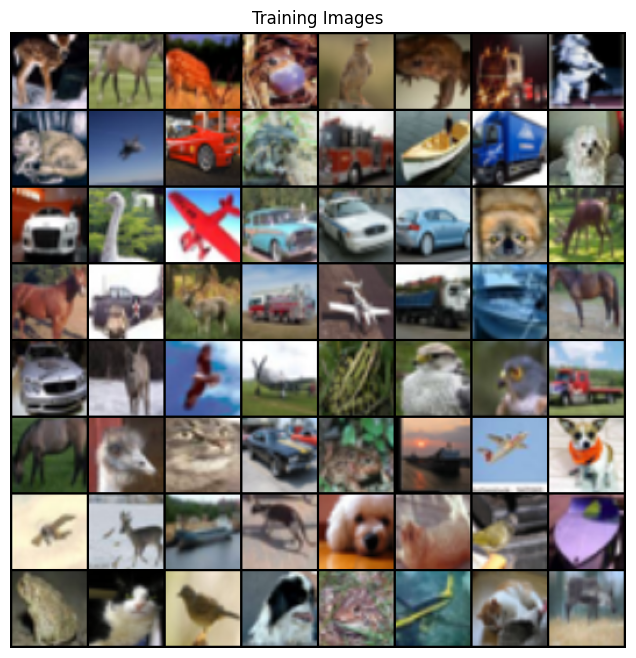

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64],
                                         padding=2, normalize=True),
                        (1, 2, 0)))

In [ ]:
##########################
### MODEL
##########################


model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v3_small',
                       pretrained=False)

model.classifier[-1] = torch.nn.Linear(in_features=1024, # as in original
                                       out_features=10) # number of class labels in Cifar-10)

model = model.to(DEVICE)

Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


hello
Epoch: 001/030 | Batch 0000/0351 | Loss: 2.3075
Epoch: 001/030 | Batch 0100/0351 | Loss: 1.8805
Epoch: 001/030 | Batch 0200/0351 | Loss: 1.7373
Epoch: 001/030 | Batch 0300/0351 | Loss: 1.7433
Epoch: 001/030 | Train: 23.90% | Validation: 23.46% | Best Validation (Ep. 001): 23.46%
Time elapsed: 1.59 min
hello
Epoch: 002/030 | Batch 0000/0351 | Loss: 1.7677
Epoch: 002/030 | Batch 0100/0351 | Loss: 1.7045
Epoch: 002/030 | Batch 0200/0351 | Loss: 1.6638
Epoch: 002/030 | Batch 0300/0351 | Loss: 1.7646
Epoch: 002/030 | Train: 20.31% | Validation: 21.12% | Best Validation (Ep. 001): 23.46%
Time elapsed: 3.11 min
hello
Epoch: 003/030 | Batch 0000/0351 | Loss: 1.8947
Epoch: 003/030 | Batch 0100/0351 | Loss: 1.4418
Epoch: 003/030 | Batch 0200/0351 | Loss: 1.5866
Epoch: 003/030 | Batch 0300/0351 | Loss: 1.7024
Epoch: 003/030 | Train: 35.82% | Validation: 36.32% | Best Validation (Ep. 003): 36.32%
Time elapsed: 4.63 min
hello
Epoch: 004/030 | Batch 0000/0351 | Loss: 1.4959
Epoch: 004/030 | Ba

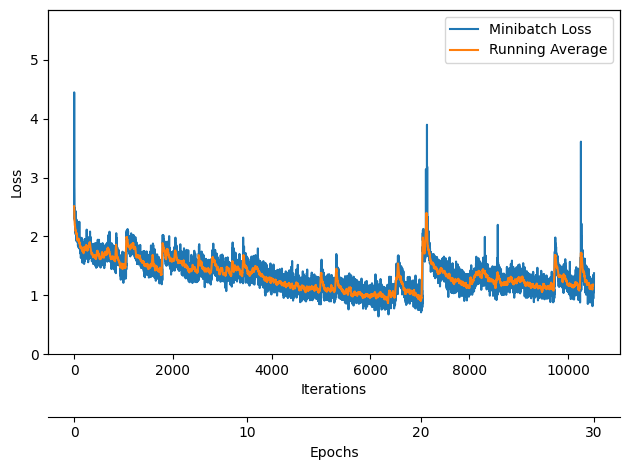

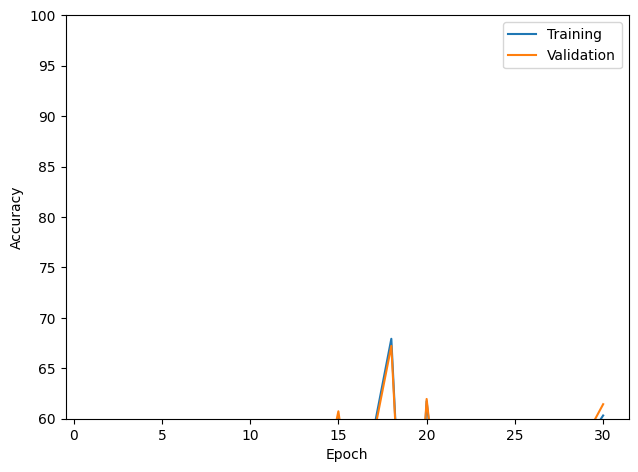

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

minibatch_loss_list, train_acc_list, valid_acc_list,model = train_classifier_simple_v2(
    model=model,
    num_epochs=30,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    best_model_save_path='mobilenet-v3-best-1.pt',
    device=DEVICE,
    scheduler_on='valid_acc',
    logging_interval=100)


plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=30,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([30, 100])
plt.show()

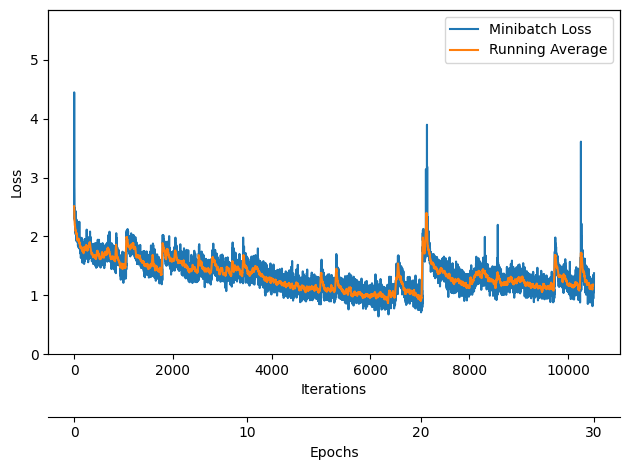

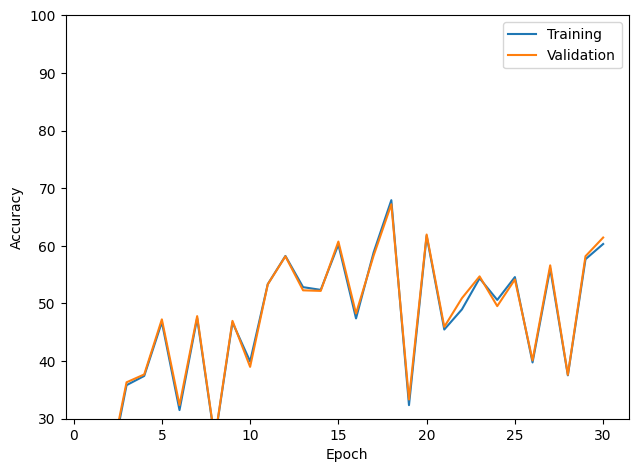

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=30,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([30, 100])
plt.show()

In [ ]:
def train_classifier_simple_v2(
        model, num_epochs, train_loader,
        valid_loader, test_loader, optimizer,
        device, logging_interval=50,
        best_model_save_path=None,
        scheduler=None,
        skip_train_acc=False,
        scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    best_valid_acc, best_epoch = -float('inf'), 0

    for epoch in range(num_epochs):
        print("hello")
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            if not skip_train_acc:
                train_acc = compute_accuracy(model, train_loader, device=device).item()
            else:
                train_acc = float('nan')
            valid_acc = compute_accuracy(model, valid_loader, device=device).item()
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

            if valid_acc > best_valid_acc:
                best_valid_acc, best_epoch = valid_acc, epoch+1
                if best_model_save_path:
                    torch.save(model.state_dict(), best_model_save_path)

            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}% '
                  f'| Best Validation '
                  f'(Ep. {best_epoch:03d}): {best_valid_acc :.2f}%')

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError('Invalid `scheduler_on` choice.')

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')
    print("DOne")
    return minibatch_loss_list, train_acc_list, valid_acc_list,model

In [ ]:
torch.save(model.state_dict(), 'trained_mobilenet_v3.pth')

In [ ]:
load_state_dict = torch.load('trained_mobilenet_v3.pth')

Image Classification:

tensor([[ 0.0026,  0.0243, -0.0281,  0.0132,  0.0248,  0.0116,  0.0180,  0.0185,
          0.0178, -0.0281]])
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


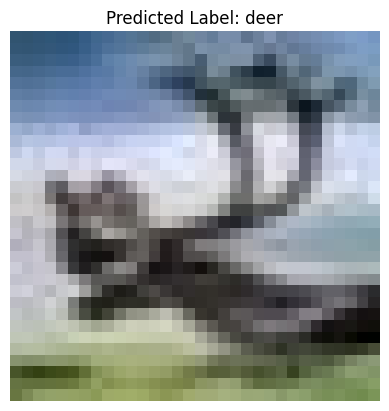

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

def predict_image_label(model, image_tensor, label_map):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Forward pass to get predictions
        output = model(image_tensor)
        print(output)
        print(label_map)
        predicted_index = torch.argmax(output, 1).item()
        predicted_label = label_map[predicted_index]

    return predicted_label

# Assuming 'model' is the trained model and you have the image tensor 'input_image_tensor'
# 'label_map' is a list or dictionary containing class labels
label_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Load and preprocess the image (Replace this step with your image loading process)
input_image = plt.imread('0004.jpg')
# Perform necessary transformations to get it in the format expected by the model
# For example, converting to PyTorch tensor and normalizing
preprocess = transforms.Compose([
    # Converts PIL Image to tensor
    # Add other transformations like normalization if required
     transforms.ToTensor(),
])

input_image_tensor = preprocess(input_image).unsqueeze(0)
model = model.to(DEVICE)

# Assuming 'input_image_tensor' is on the device specified by 'device'
# Move the input tensor to the same device as the model
input_image_tensor = input_image_tensor.to(DEVICE)

# Call the function to get the predicted label
predicted_label = predict_image_label(model, input_image_tensor, label_map)

# Display the image along with the predicted label
plt.imshow(input_image)
plt.axis('off')
plt.title(f'Predicted Label: {predicted_label}')
plt.show()


In [ ]:

%ls

cnn-alexnet-cifar10-grouped.ipynb       cnn-resnet34-celeba-dataparallel.ipynb
cnn-alexnet-cifar10.ipynb               cnn-resnet34-cifar10-pinmem.ipynb
cnn-allconv.ipynb                       cnn-resnet34-mnist.ipynb
cnn-basic.ipynb                         cnn-resnet34-quickdraw.ipynb
cnn-densenet121-cifar10.ipynb           cnn-resnet50-celeba-dataparallel.ipynb
cnn-densenet121-mnist.ipynb             cnn-resnet50-mnist.ipynb
cnn-embetter-mobilenet.ipynb            cnn-standardized.ipynb
cnn-he-init.ipynb                       cnn-vgg16-cats-dogs.ipynb
cnn-lenet5-cifar10.ipynb                cnn-vgg16-celeba-data-parallel.ipynb
cnn-lenet5-mnist.ipynb                  cnn-vgg16-celeba.ipynb
cnn-lenet5-quickdraw.ipynb              cnn-vgg16.ipynb
cnn-mobilenet-v2-cifar10.ipynb          cnn-vgg19.ipynb
cnn-mobilenet-v3-large-cifar10.ipynb    data/
cnn-mobilenet-v3-small-cifar10.ipynb    fc-to-conv.ipynb
cnn-resnet101-celeba.ipynb              images/
cnn-resnet101-cifar10.ipynb          

In [ ]:
print(type(model))

<class 'torchvision.models.mobilenetv3.MobileNetV3'>


In [ ]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v3_small',
                       pretrained=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
